In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub
from scipy.stats import truncnorm
import numpy as np
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
# Setup
module = hub.Module('https://tfhub.dev/deepmind/biggan-128/2')

input_info = module.get_input_info_dict('default')
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().items()}

output = module(inputs)

input_z = inputs['z']
input_y = inputs['y']
input_trunc = inputs['truncation']

initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

graph = tf.get_default_graph()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
# Sampling
z = truncnorm.rvs(-2, 2, size=(1, 120),)
y = np.zeros(shape=(1, 1000))
y[:, 933] = 1.

feed_dict = {input_z: z, input_y: y, input_trunc: 1.}
image = sess.run(output, feed_dict=feed_dict)
plt.imshow(image[0] * 0.5 + 0.5)

In [3]:
embedding_tensor = tf.get_default_graph().get_tensor_by_name('module_apply_default/linear/MatMul:0')
embedding_out = tf.get_variable(name='embedding_out', dtype=embedding_tensor.dtype, shape=embedding_tensor.shape)

In [4]:
get_embedding = tf.assign(embedding_out, embedding_tensor)

Tensor("module_apply_default/linear/MatMul:0", shape=(1, 128), dtype=float32) Tensor("module_apply_default/linear/MatMul:0", shape=(1, 128), dtype=float32)
-0.69154215 0.5217318 -0.030656641 0.19380054


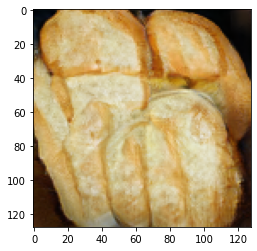

In [5]:
# Sampling, with attempt to hook class embedding

embedding_module = tf.get_default_graph().get_operation_by_name('module_apply_default/linear/MatMul')
embedding_output = embedding_module.outputs[0]

embedding_tensor = tf.get_default_graph().get_tensor_by_name('module_apply_default/linear/MatMul:0')


z = truncnorm.rvs(-2, 2, size=(1, 120),)
y = np.zeros(shape=(1, 1000))
y[:, 930] = 1.

feed_dict = {input_z: z, input_y: y, input_trunc: 1.}
image, embedding = sess.run([output, get_embedding], feed_dict=feed_dict)
plt.imshow(image[0] * 0.5 + 0.5)
#print(np.array(embedding_tensor))

print(embedding.min(), embedding.max(), embedding.mean(), embedding.std())

In [11]:
# List operations that match the embedding shape of (1, 128)

operations = tf.get_default_graph().get_operations()
ops = [op for op in operations if any(
    output.shape == tf.TensorShape((1, 128)) for output in op.outputs
)]
ops

[<tf.Operation 'module/linear/MatMul' type=MatMul>,
 <tf.Operation 'module_apply_default/linear/MatMul' type=MatMul>]

In [12]:
tf.get_default_graph().get_tensor_by_name('module_apply_default/linear/MatMul:0')

<tf.Tensor 'module_apply_default/linear/MatMul:0' shape=(1, 128) dtype=float32>

In [14]:
graph.get_operation_by_name('module_apply_default/linear/MatMul').inputs

(<tf.Tensor 'module_apply_default/dummy_y:0' shape=(1, 1000) dtype=float32>,
 <tf.Tensor 'module_apply_default/linear/MatMul/ReadVariableOp:0' shape=(1000, 128) dtype=float32>)

In [17]:
embedding_variables = [var for var in graph.get_collection('variables', scope=None) 
                       if var.shape == (1000, 128)]

In [40]:
from pathlib import Path

embedding_matrix = embedding_variables[0].eval(session=sess)
embedding_matrix_ema = embedding_variables[1].eval(session=sess)

out_folder = Path('X:\\Datasets\\Deep-Image-Reconstruction\\derivatives')
np.save(out_folder / 'biggan-128_embedding-matrix.npy', embedding_matrix)
np.save(out_folder / 'biggan-128_embedding-matrix-ema.npy', embedding_matrix_ema)